# Checking GPU Enabled

In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Aug 11 13:43:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    79W / 149W |  10870MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#Installing additional Libraries

In [2]:
import math
import numpy as np
import keras
import cv2

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPool2D, ZeroPadding2D, Cropping2D, Softmax, Add, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import Sequence

from IPython.display import clear_output
import matplotlib.pyplot as plt

# Downloading the Dataset

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
if "imgVOC" not in os.listdir("/content"):
  !unzip "/content/drive/My Drive/VOC/img_VOC.zip"
if "SegmentationClassConvertedMin" not in os.listdir("/content"):
  !unzip "/content/drive/My Drive/VOC/mask_VOC.zip"

Archive:  /content/drive/My Drive/VOC/img_VOC.zip
   creating: imgVOC/
  inflating: imgVOC/2007_000032.npy  
  inflating: imgVOC/2007_000033.npy  
  inflating: imgVOC/2007_000039.npy  
  inflating: imgVOC/2007_000042.npy  
  inflating: imgVOC/2007_000061.npy  
  inflating: imgVOC/2007_000063.npy  
  inflating: imgVOC/2007_000068.npy  
  inflating: imgVOC/2007_000121.npy  
  inflating: imgVOC/2007_000123.npy  
  inflating: imgVOC/2007_000129.npy  
  inflating: imgVOC/2007_000170.npy  
  inflating: imgVOC/2007_000175.npy  
  inflating: imgVOC/2007_000187.npy  
  inflating: imgVOC/2007_000241.npy  
  inflating: imgVOC/2007_000243.npy  
  inflating: imgVOC/2007_000250.npy  
  inflating: imgVOC/2007_000256.npy  
  inflating: imgVOC/2007_000323.npy  
  inflating: imgVOC/2007_000332.npy  
  inflating: imgVOC/2007_000333.npy  
  inflating: imgVOC/2007_000346.npy  
  inflating: imgVOC/2007_000363.npy  
  inflating: imgVOC/2007_000364.npy  
  inflating: imgVOC/2007_000392.npy  
  inflating: imgV

In [5]:
TRAIN_FILE_NAMES=open("/content/drive/My Drive/VOC/train.txt").read().split()
VAL_FILE_NAMES=open("/content/drive/My Drive/VOC/val.txt").read().split()

In [6]:
def open_image(name, path):
    with open(path + '/' + name+".npy", 'rb') as f:
        return np.load(f) 

#Important Hyperparameters

In [7]:
IMAGE_SHAPE=(500,500,3)
N_CLASSES=22
L2_VALUE=5**-4

BATCH_SIZE = 20
BUFFER_SIZE = 1000
EPOCHS = 500
VAL_SUBSPLITS = 5

DATASET_PATH = "/content"
IMAGE_PATH = DATASET_PATH + '/imgVOC'
MASK_PATH = DATASET_PATH + '/SegmentationClassConvertedMin'

TRAIN_LENGTH = len(TRAIN_FILE_NAMES)
VALIDATION_STEPS = len(VAL_FILE_NAMES)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Taking a look at the dataset

In [8]:
def print_img(img):
    plt.figure(figsize=(14, 7))
    plt.subplot(1,1,1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Lena'), plt.axis('off')
    
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    if (len(display_list)>1 and len(display_list[1].shape)==2):
      display_list[1] = np.expand_dims(display_list[1],axis=2)

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(num=1):
    for i in range(num if num < len(example_images) else len(example_images)):  
        n = len(example_images)-i-1
        pred_mask = create_mask(model(np.expand_dims(example_images[i],axis=0)))
        display([example_images[n], example_masks[n], pred_mask])

In [9]:
number_of_examples = 10

example_images = []
example_masks = []
for i, img_id in enumerate(VAL_FILE_NAMES):
    example_images.append(open_image(img_id, IMAGE_PATH))
    example_masks.append(open_image(img_id, MASK_PATH))
    
    if i==number_of_examples:
        break

# Defining the models

In [10]:
class Crop(tf.keras.layers.Layer):
  def call(self, inputs):
    x1, x2 = inputs
    x1_shape = tf.shape(x1)
    x2_shape = tf.shape(x2)
    # offsets for the top left corner of the crop
    offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
    size = [-1, x2_shape[1], x2_shape[2], -1]
    x1_crop = tf.slice(x1, offsets, size)
    return x1_crop

## Base Vgg Architecture

In [11]:
def create_base_vgg(trainable=True):
  tf.keras.backend.clear_session()
  #Defining Base VGG architecture
  input_layer = Input(shape=(None,None,3), name="input")
  #VGG-block1
  b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv2d_b1_1")(input_layer)
  b1 = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv2d_b1_2")(b1)
  b1 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b1")(b1)

  #VGG-block2
  b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b2_1")(b1)
  b2 = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b2_2")(b2)
  b2 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b2")(b2)

  #VGG-block3
  b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_1")(b2)
  b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_2")(b3)
  b3 = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b3_3")(b3)
  b3 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b3")(b3)

  #VGG-block4
  b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_1")(b3)
  b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_2")(b4)
  b4 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b4_3")(b4)
  b4 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b4")(b4)

  #VGG-block5
  b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_1")(b4)
  b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_2")(b5)
  b5 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name="conv2d_b5_3")(b5)
  b5 = MaxPool2D(pool_size=(2,2),strides=(2,2), name="maxpool_b5")(b5)

  vgg_model = Model(input_layer, b5)
  vgg16= VGG16(weights="imagenet", include_top=False)
  vgg16.save_weights("./weights.h5")
  vgg_model.load_weights("./weights.h5")
  vgg_model.trainable=trainable

  return vgg_model

## FCN-32

In [12]:
def create_fcn32(vgg_trainable=True, include_top=True):
  vgg_model=create_base_vgg(trainable=vgg_trainable)
  b5=vgg_model.layers[-1].output
  input_layer=vgg_model.layers[0].output
  fcn_32_block = Conv2D(4096, kernel_size=(7,7), activation='relu', padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_1")(b5)
  fcn_32_block = Dropout(0.5, name="dropout_fcn32_1")(fcn_32_block)
  fcn_32_block = Conv2D(4096, kernel_size=(1,1), activation='relu', padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_2")(fcn_32_block)
  fcn_32_block = Dropout(0.5, name="dropout_fcn32_2")(fcn_32_block)
  fcn_32_block = Conv2D(N_CLASSES, kernel_size=(1,1), padding="same", kernel_regularizer=l2(L2_VALUE), name="conv2d_fcn32_3")(fcn_32_block)
  if include_top:
    fcn_32_transpose = Conv2DTranspose(N_CLASSES, kernel_size=(64,64), strides=(32,32), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn32")(fcn_32_block)
    fcn_32_crop = Crop()([fcn_32_transpose, input_layer])
    fcn_32_softmax=Softmax(name="softmax_fcn32")(fcn_32_crop)
    return Model(input_layer, fcn_32_softmax)
  else:
    return Model(input_layer, fcn_32_block)

##FCN-16

In [13]:
def create_fcn16(vgg_trainable=True, include_top=True):
  fcn_32=create_fcn32(vgg_trainable=vgg_trainable, include_top=False)
  input_layer=fcn_32.layers[0].output
  b4=fcn_32.get_layer("maxpool_b4").output
  fcn_32_block=fcn_32.layers[-1].output

  fcn_16_block_fcn32 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn16_1")(fcn_32_block)
  fcn_16_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", kernel_regularizer=l2(L2_VALUE), padding="valid", name="conv2d_fcn16_1")(b4)

  fcn_16_block_fcn32 = Crop()([fcn_16_block_fcn32,fcn_16_block])

  fcn_16_block = Add(name="add_fcn16")([fcn_16_block_fcn32,fcn_16_block])

  if include_top:
    fcn_16_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(32,32), strides=(16,16), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fcn16_2")(fcn_16_block)
    fcn_16_crop = Crop()([fcn_16_deconv,input_layer])
    fcn_16_softmax=Softmax(name="softmax_fcn16")(fcn_16_crop)
    return Model(input_layer, fcn_16_softmax)
  else:
    return Model(input_layer, fcn_16_block)

##FCN-8

In [14]:
def create_fcn8(vgg_trainable=True, include_top=True):
  fcn_16=create_fcn16(vgg_trainable=vgg_trainable, include_top=False)
  input_layer=fcn_16.layers[0].output
  b3=fcn_16.get_layer("maxpool_b3").output
  fcn_16_block=fcn_16.layers[-1].output

  fcn_8_block_fcn16 = Conv2DTranspose(N_CLASSES, kernel_size=(4,4), padding="valid", strides=(2,2), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fnc8_1")(fcn_16_block)
  fcn_8_block = Conv2D(N_CLASSES, kernel_size=(1,1), activation="relu", kernel_regularizer=l2(L2_VALUE), padding="valid", name="conv2d_fcn8_1")(b3)
  
  fcn_8_block_fcn16 = Crop()([fcn_8_block_fcn16,fcn_8_block])
  
  fcn_8_block = Add(name="add_fcn8")([fcn_8_block_fcn16,fcn_8_block])

  if include_top:
    fcn_8_deconv = Conv2DTranspose(N_CLASSES, kernel_size=(16,16), strides=(8,8), kernel_regularizer=l2(L2_VALUE), use_bias=False, name="deconv_fnc8_2")(fcn_8_block)
    fcn_8_crop = Crop()([fcn_8_deconv,input_layer])
    fcn_8_softmax=Softmax(name="softmax_fcn8")(fcn_8_crop)
    return Model(input_layer, fcn_8_softmax)
  else:
    return Model(input_layer, fcn_8_block)

#Training the model

##Defining Useful Callbacks

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [16]:
class print_lr(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print("Current Learning rate : {}".format(self.model.optimizer.lr.numpy()))

In [17]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=10**-10)

In [18]:
csv_logger = tf.keras.callbacks.CSVLogger("/content/drive/My Drive/VOC/results.csv", separator=";", append=True)

In [19]:
callbacks=[
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ModelCheckpoint("/content/drive/My Drive/VOC/best_model_weights.h5", save_best_only=True, verbose=1, save_only_weights=True),
    DisplayCallback(),
    csv_logger,
    reduce_lr, 
    print_lr(),
]

##Defining custom mean_iou metric

In [20]:
class AdaptedMeanIoU(tf.keras.metrics.Metric):
  def __init__(self, name='mean_iou', n_classes=3,**kwargs):
    super(AdaptedMeanIoU, self).__init__(name=name, **kwargs)
    self.mean_iou=MeanIoU(n_classes)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred_converted=tf.argmax(y_pred,axis=-1)
    self.mean_iou.update_state(y_true,y_pred_converted)
  def result(self):
    return self.mean_iou.result()
  def reset_states(self):
    self.mean_iou.reset_states()

## Data Generator

In [21]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs, image_path, mask_path, to_fit=True, batch_size=32, shuffle=True):
        self.list_IDs = list_IDs
        self.image_path=image_path
        self.mask_path=mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        X = []
        for i, ID in enumerate(list_IDs_temp):
            X.append(open_image(ID, self.image_path))
        return np.array(X)

    def _generate_y(self, list_IDs_temp):
        y = []
        for i, ID in enumerate(list_IDs_temp):
            y.append(open_image(ID, self.mask_path))
        return np.array(y)

## Execute Training

### Training FCN8

58892288/58889256 [==============================] - 1s 0us/step


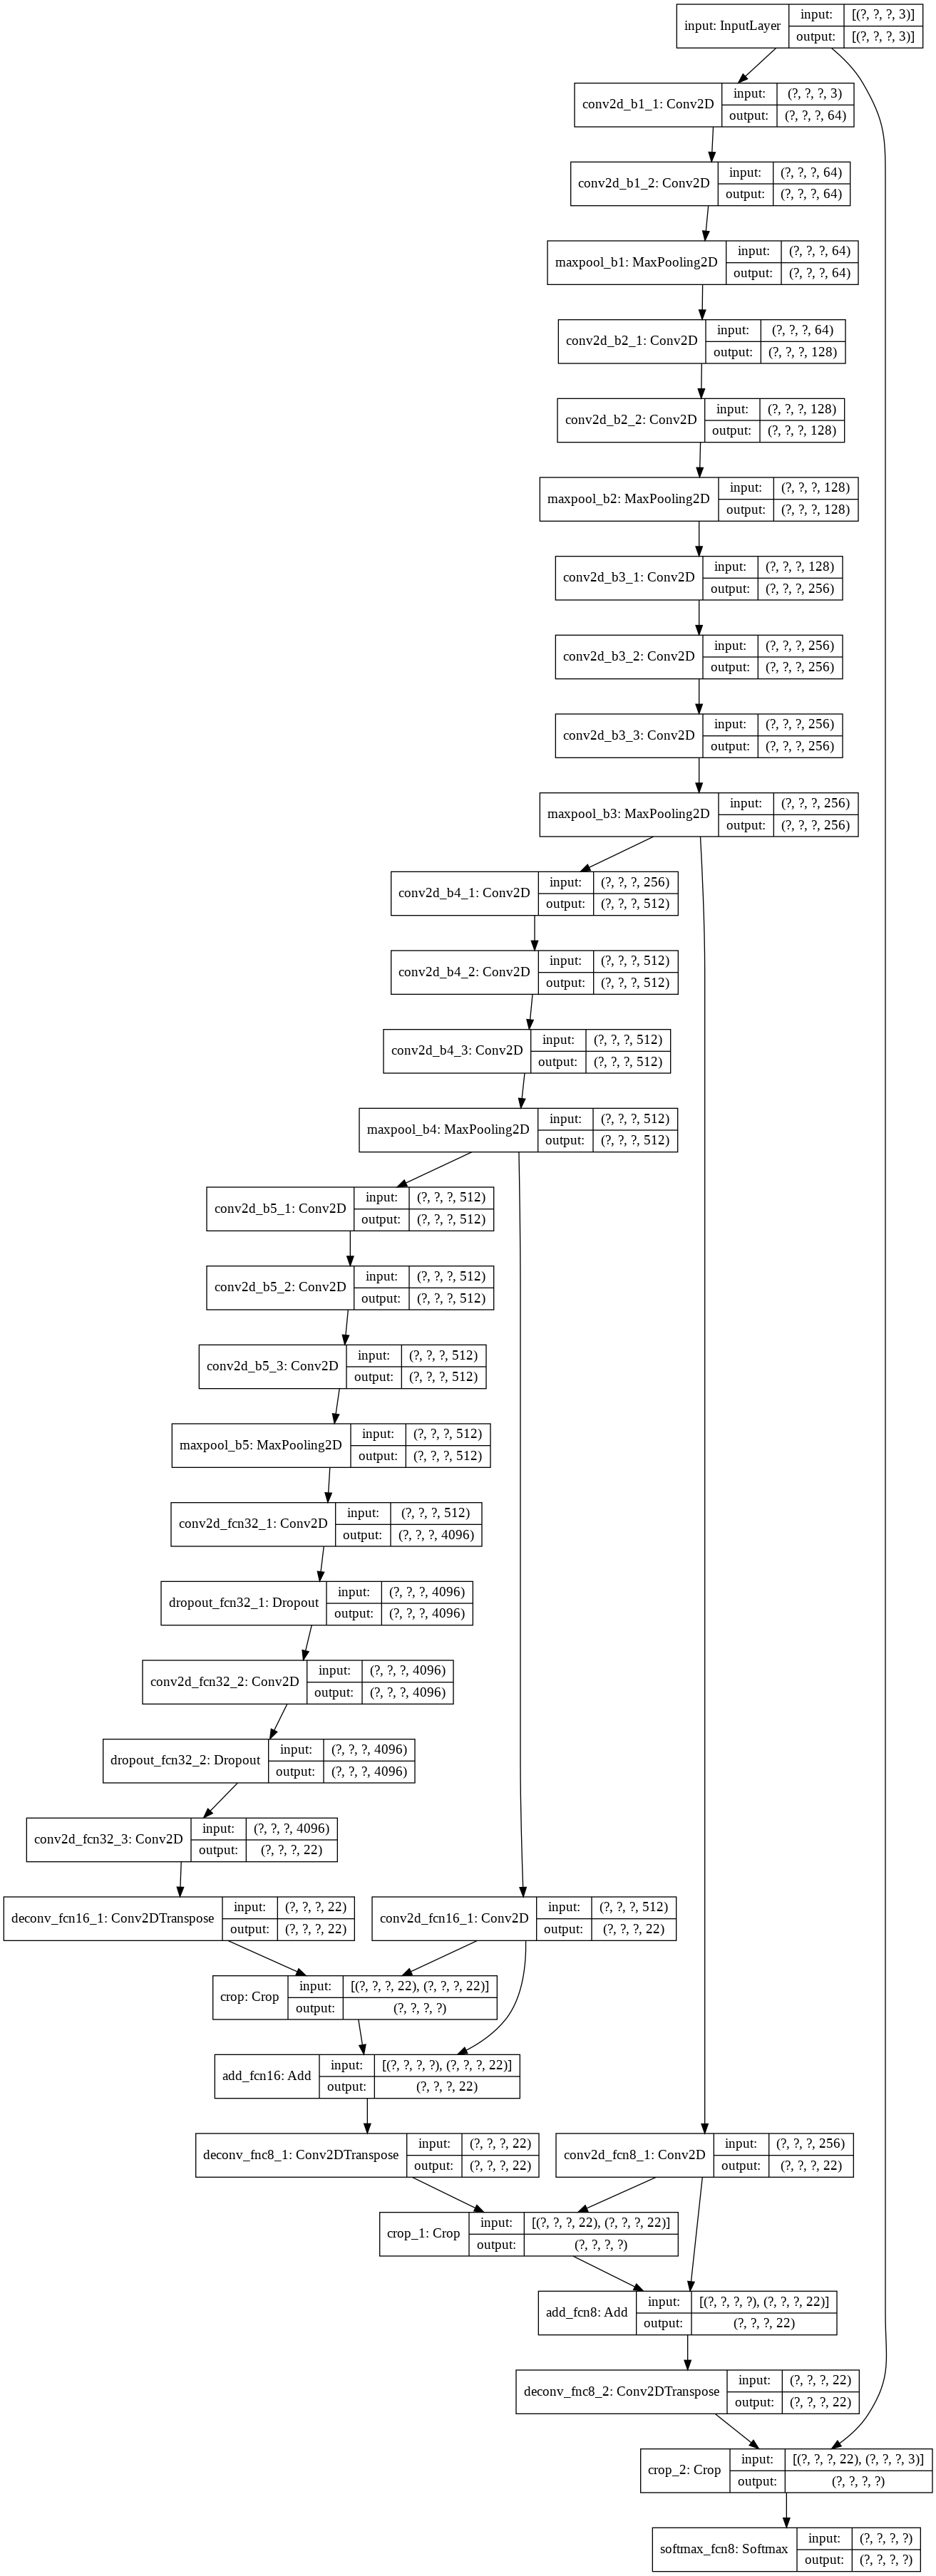

In [22]:
model=create_fcn8()
model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, clipnorm=1), loss=SparseCategoricalCrossentropy(), metrics=[AdaptedMeanIoU(n_classes=N_CLASSES)])
tf.keras.utils.plot_model(model, show_shapes=True)

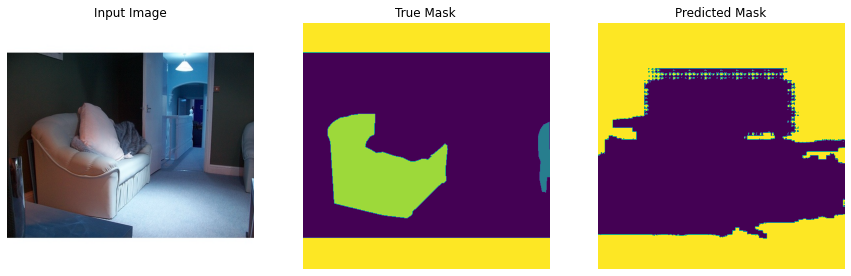


Sample Prediction after epoch 3

55/55 [==============================] - 406s 7s/step - loss: 4.8322 - mean_iou: 0.0631 - val_loss: 4.1509 - val_mean_iou: 0.0658
Current Learning rate : 0.10000000149011612
Epoch 4/500


ResourceExhaustedError: ignored

In [23]:
generator_train = DataGenerator(TRAIN_FILE_NAMES, image_path=IMAGE_PATH, mask_path=MASK_PATH,
                          to_fit=True, batch_size=BATCH_SIZE,shuffle=True)

generator_val = DataGenerator(VAL_FILE_NAMES, image_path=IMAGE_PATH, mask_path=MASK_PATH,
                          to_fit=True, batch_size=BATCH_SIZE,shuffle=True)

model_history = model.fit(generator_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          callbacks=callbacks, validation_data=generator_val)

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [ ]:
show_predictions(10)